[INFO] Loaded 100000 points from oakland_part2_ac.xyz_label_conf
[INFO] Class mapping: {np.int64(1001): 0, np.int64(1002): 1, np.int64(1003): 2, np.int64(1102): 3, np.int64(1110): 4, np.int64(1111): 5, np.int64(1119): 6, np.int64(1200): 7, np.int64(1203): 8, np.int64(1206): 9, np.int64(1300): 10, np.int64(1301): 11, np.int64(1302): 12, np.int64(1303): 13, np.int64(1305): 14, np.int64(1400): 15, np.int64(1401): 16, np.int64(1402): 17, np.int64(1410): 18, np.int64(1411): 19, np.int64(1501): 20}
[INFO] Class counts: Counter({np.int64(8): 47710, np.int64(7): 18946, np.int64(10): 11675, np.int64(15): 9811, np.int64(20): 3102, np.int64(16): 2664, np.int64(9): 2016, np.int64(0): 952, np.int64(11): 849, np.int64(19): 751, np.int64(18): 377, np.int64(17): 250, np.int64(13): 204, np.int64(5): 140, np.int64(14): 131, np.int64(12): 128, np.int64(2): 121, np.int64(4): 69, np.int64(6): 60, np.int64(3): 33, np.int64(1): 11})
[INFO] Train points: 80000, Test points: 20000
Epoch 1/25  train_loss=1.0075

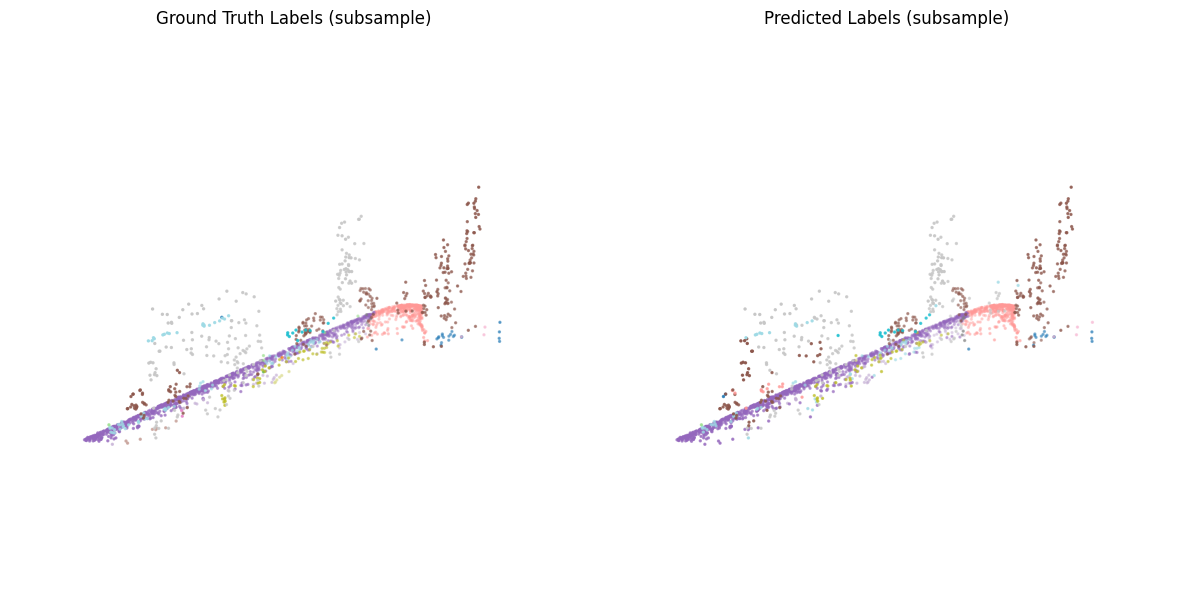

[INFO] Saved visualization to 'segmentation_visualization_fixed.png'


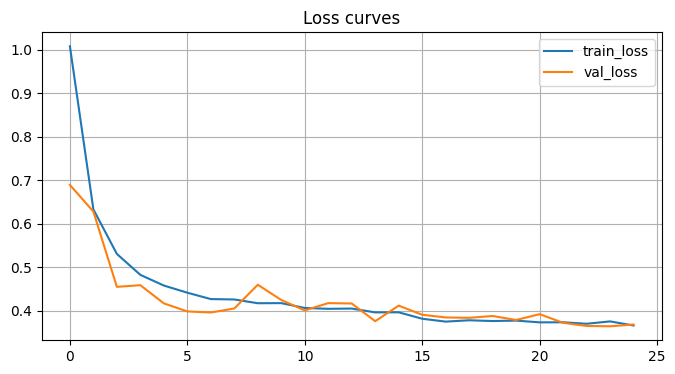

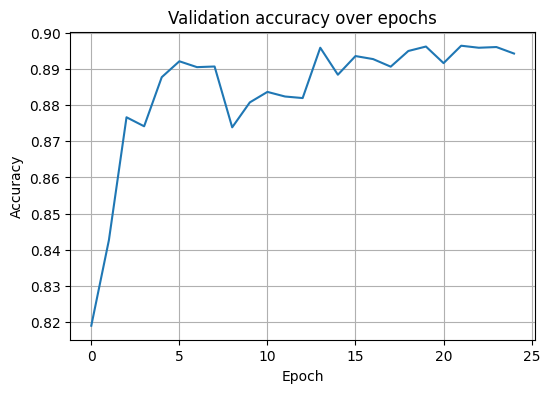

[INFO] Checkpoint (best) saved as: simple_pointnet_seg_fixed.pth
[DONE]


In [ ]:
# train_pointnet_seg_fixed.py
"""
Fixed PointNet-style per-point segmentation demo.
- Fixes the loss-shape bug (use logits.view(-1, num_classes))
- Adds class weights
- Safer dataloader worker count
- Optional overfit debug mode
- Visualizations saved as PNG
"""

import os, time, math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# === USER PARAMETERS ===
FNAME = "oakland_part2_ac.xyz_label_conf"   # change to your filename if needed
NUM_POINTS = 2048
BATCH_SIZE = 8
NUM_EPOCHS = 25
NUM_WORKERS = 2      # keep small if your system warns
LEARNING_RATE = 1e-3
OVERFIT_DEBUG = False  # Set True to run tiny overfit test (sanity check)
SAVE_MODEL = "simple_pointnet_seg_fixed.pth"
# ========================

def load_xyz_label_conf(path):
    data = np.loadtxt(path)
    if data.ndim == 1:
        data = data.reshape(1, -1)
    if data.shape[1] < 4:
        raise ValueError("Expected at least 4 columns (x y z label)")
    points = data[:, :3].astype(np.float32)
    labels = data[:, 3].astype(np.int64)
    return points, labels

# Load or generate synthetic demo
if not os.path.exists(FNAME):
    print(f"[INFO] File '{FNAME}' not found. Generating synthetic demo data...")
    rng = np.random.RandomState(42)
    n_ground, n_wall, n_blob = 6000, 3000, 4000
    ground = np.column_stack((rng.uniform(-20,20,n_ground), rng.uniform(-20,20,n_ground), rng.normal(0.0,0.05,n_ground)))
    wall = np.column_stack((rng.normal(5.0,0.3,n_wall), rng.uniform(-10,10,n_wall), rng.uniform(0,4,n_wall)))
    blob = np.column_stack((rng.normal(-5,1.0,n_blob), rng.normal(5,1.0,n_blob), rng.normal(1.0,0.5,n_blob)))
    points = np.vstack([ground, wall, blob]).astype(np.float32)
    labels = np.hstack([np.zeros(n_ground,dtype=np.int64), np.ones(n_wall,dtype=np.int64), np.full(n_blob,2,dtype=np.int64)])
else:
    points, labels = load_xyz_label_conf(FNAME)
    print(f"[INFO] Loaded {points.shape[0]} points from {FNAME}")

# Remap labels to contiguous 0..K-1
unique_labels = np.unique(labels)
label_map = {lab: i for i, lab in enumerate(unique_labels)}
labels_mapped = np.array([label_map[l] for l in labels], dtype=np.int64)
num_classes = len(unique_labels)
print("[INFO] Class mapping:", label_map)
print("[INFO] Class counts:", Counter(labels_mapped))

# Partition: if OVERFIT_DEBUG, use tiny subset for train and val (sanity check)
if OVERFIT_DEBUG:
    N_debug = min(4096, points.shape[0])
    pts_subset = points[:N_debug]
    lbl_subset = labels_mapped[:N_debug]
    pts_train, pts_test, lbl_train, lbl_test = train_test_split(pts_subset, lbl_subset, test_size=0.2, random_state=42, stratify=lbl_subset)
else:
    # Standard random point split for demo (for real experiments use spatial split Part2/Part3)
    pts_train, pts_test, lbl_train, lbl_test = train_test_split(points, labels_mapped, test_size=0.2, random_state=42, stratify=labels_mapped)

print(f"[INFO] Train points: {pts_train.shape[0]}, Test points: {pts_test.shape[0]}")

# Dataset that samples fixed-size point clouds by random sampling
class SingleFilePointDataset(Dataset):
    def __init__(self, points, labels, num_points=2048, augment=True, mode='train'):
        self.points = points
        self.labels = labels
        self.N = points.shape[0]
        self.num_points = num_points
        self.augment = augment if mode=='train' else False
        self.mode = mode
    def __len__(self):
        return max(1000, (self.N // self.num_points) * 20)
    def __getitem__(self, idx):
        choices = np.random.choice(self.N, self.num_points, replace=(self.N < self.num_points))
        pts = self.points[choices].copy()
        lbl = self.labels[choices].copy()
        if self.augment:
            theta = np.random.uniform(0, 2*math.pi)
            c, s = math.cos(theta), math.sin(theta)
            R = np.array([[c, -s, 0],[s, c, 0],[0,0,1]], dtype=np.float32)
            pts = pts.dot(R.T)
            pts += np.random.normal(0, 0.01, pts.shape).astype(np.float32)
            scale = np.random.uniform(0.95, 1.05)
            pts *= scale
        # center per-sample
        pts = pts - pts.mean(axis=0, keepdims=True)
        return torch.from_numpy(pts.astype(np.float32)), torch.from_numpy(lbl.astype(np.int64))

train_dataset = SingleFilePointDataset(pts_train, lbl_train, num_points=NUM_POINTS, augment=True, mode='train')
val_dataset   = SingleFilePointDataset(pts_test, lbl_test, num_points=NUM_POINTS, augment=False, mode='val')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Tiny PointNet-like architecture (per-point MLP)
class SimplePointNetSeg(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.mlp1 = nn.Sequential(nn.Linear(in_channels, 64), nn.ReLU(), nn.BatchNorm1d(64))
        self.mlp2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.BatchNorm1d(128))
        self.mlp3 = nn.Sequential(nn.Linear(128, 256), nn.ReLU(), nn.BatchNorm1d(256))
        self.classifier = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, num_classes))
    def forward(self, x):
        # x: (B, P, C)
        B, P, C = x.shape
        x = x.view(B*P, C)
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)
        logits = self.classifier(x)   # (B*P, num_classes)
        logits = logits.view(B, P, -1)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointNetSeg(in_channels=3, num_classes=num_classes).to(device)

# Compute class weights from training labels (inverse-log smoothing)
train_counts = Counter(lbl_train)
counts = np.array([train_counts.get(i, 0) for i in range(num_classes)], dtype=np.float32)
# avoid division by zero
counts = np.clip(counts, a_min=1.0, a_max=None)
class_weights = 1.0 / (np.log(1.2 + counts))
class_weights = torch.from_numpy(class_weights).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

# Training loop with corrected loss flattening
history = {"train_loss": [], "val_loss": [], "val_acc": []}
best_val = 0.0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for pts_batch, lbl_batch in train_loader:
        pts_batch = pts_batch.to(device)   # (B,P,3)
        lbl_batch = lbl_batch.to(device)   # (B,P)
        optimizer.zero_grad()
        logits = model(pts_batch)          # (B,P,C)
        # === CORRECT LOSS CALL ===
        loss = criterion(logits.view(-1, num_classes), lbl_batch.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / max(1, len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for pts_batch, lbl_batch in val_loader:
            pts_batch = pts_batch.to(device)
            lbl_batch = lbl_batch.to(device)
            logits = model(pts_batch)
            val_loss += criterion(logits.view(-1, num_classes), lbl_batch.view(-1)).item()
            preds = logits.argmax(dim=2)  # (B,P)
            total += preds.numel()
            correct += (preds == lbl_batch).sum().item()
    avg_val_loss = val_loss / max(1, len(val_loader))
    val_acc = correct / total if total>0 else 0.0

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # scheduler step and checkpoint
    scheduler.step()
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), SAVE_MODEL)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  train_loss={avg_train_loss:.4f}  val_loss={avg_val_loss:.4f}  val_acc={val_acc:.4f}  best_val={best_val:.4f}")

elapsed = time.time() - start_time
print(f"[INFO] Training finished in {elapsed/60:.2f} minutes. Best val acc: {best_val:.4f}")

# ----------------
# Inference on a subsample for visualization
# ----------------
n_vis = min(5000, pts_test.shape[0])
vis_idx = np.random.choice(pts_test.shape[0], n_vis, replace=False)
vis_pts = pts_test[vis_idx].astype(np.float32)
vis_lbl = lbl_test[vis_idx]

# Sample or pad to NUM_POINTS for single-batch prediction
if vis_pts.shape[0] >= NUM_POINTS:
    sel = np.random.choice(vis_pts.shape[0], NUM_POINTS, replace=False)
    inp_pts = vis_pts[sel]
    vis_lbl_sel = vis_lbl[sel]
else:
    reps = NUM_POINTS - vis_pts.shape[0]
    extra = np.random.choice(vis_pts.shape[0], reps, replace=True)
    inp_pts = np.vstack([vis_pts, vis_pts[extra]])
    vis_lbl_sel = np.hstack([vis_lbl, vis_lbl[extra]])

inp = torch.from_numpy((inp_pts - inp_pts.mean(axis=0, keepdims=True)).astype(np.float32)).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(inp)                          # (1, P, C)
    preds = logits.argmax(dim=2).cpu().numpy().squeeze()  # (P,)

# Visualization (ground truth vs predicted)
cmap = plt.get_cmap("tab20")
def labels_to_colors(lbls):
    max_label = max(1, int(lbls.max()))
    cols = cmap(lbls / float(max_label))[:, :3]
    return cols

gt_colors = labels_to_colors(vis_lbl_sel)
pred_colors = labels_to_colors(preds)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=gt_colors, s=2)
ax1.set_title("Ground Truth Labels (subsample)")
ax1.set_axis_off()

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=pred_colors, s=2)
ax2.set_title("Predicted Labels (subsample)")
ax2.set_axis_off()

plt.tight_layout()
plt.savefig("segmentation_visualization_fixed.png", dpi=200)
plt.show()
print("[INFO] Saved visualization to 'segmentation_visualization_fixed.png'")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.grid(True)
plt.savefig("loss_curves_fixed.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["val_acc"], label="val_accuracy")
plt.title("Validation accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("val_accuracy_fixed.png", dpi=150)
plt.show()

print(f"[INFO] Checkpoint (best) saved as: {SAVE_MODEL}")
print("[DONE]")



In [ ]:
import os, time, math
from collections import Counter
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ---------- USER PARAMS ----------
FNAME = "oakland_part2_ac.xyz_label_conf"
NUM_POINTS = 2048
BATCH_SIZE = 8
NUM_EPOCHS = 25
NUM_WORKERS = 2
LR = 1e-3
SAVE_MODEL = "simple_pointnet_seg_clean.pth"
# ---------------------------------

def load_xyz_label_conf(path):
    data = np.loadtxt(path)
    if data.ndim == 1:
        data = data.reshape(1, -1)
    if data.shape[1] < 4:
        raise ValueError("Expected at least 4 columns (x y z label)")
    pts = data[:, :3].astype(np.float32)
    lbl = data[:, 3].astype(np.int64)
    return pts, lbl

# load or generate small synthetic fallback
if not os.path.exists(FNAME):
    rng = np.random.RandomState(42)
    n = 5000
    pts = np.column_stack((rng.uniform(-10,10,n), rng.uniform(-10,10,n), rng.normal(0,1,n))).astype(np.float32)
    lbl = rng.randint(0,3,size=(n,)).astype(np.int64)
else:
    pts, lbl = load_xyz_label_conf(FNAME)

# remap labels to contiguous range
unique = np.unique(lbl)
label_map = {v:i for i,v in enumerate(unique)}
lbl_mapped = np.array([label_map[x] for x in lbl], dtype=np.int64)
NUM_CLASSES = len(unique)

# train/val split
pts_train, pts_val, lbl_train, lbl_val = train_test_split(pts, lbl_mapped, test_size=0.2, random_state=42, stratify=lbl_mapped)

class SingleFilePointDataset(Dataset):
    def __init__(self, points, labels, num_points=2048, augment=False):
        self.points = points
        self.labels = labels
        self.N = points.shape[0]
        self.num_points = num_points
        self.augment = augment
    def __len__(self):
        return max(100, (self.N // self.num_points) * 5)
    def __getitem__(self, idx):
        choice = np.random.choice(self.N, self.num_points, replace=(self.N < self.num_points))
        pts = self.points[choice].copy()
        lbl = self.labels[choice].copy()
        if self.augment:
            theta = np.random.uniform(0, 2*math.pi)
            c,s = math.cos(theta), math.sin(theta)
            R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
            pts = pts.dot(R.T)
            pts += np.random.normal(0, 0.01, pts.shape).astype(np.float32)
            scale = np.random.uniform(0.95,1.05)
            pts *= scale
        pts = pts - pts.mean(axis=0, keepdims=True)
        return torch.from_numpy(pts), torch.from_numpy(lbl)

train_ds = SingleFilePointDataset(pts_train, lbl_train, num_points=NUM_POINTS, augment=True)
val_ds   = SingleFilePointDataset(pts_val, lbl_val, num_points=NUM_POINTS, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class SimplePointNetSeg(nn.Module):
    def __init__(self, in_ch=3, num_classes=3):
        super().__init__()
        self.mlp1 = nn.Sequential(nn.Linear(in_ch,64), nn.ReLU(), nn.LayerNorm(64))
        self.mlp2 = nn.Sequential(nn.Linear(64,128), nn.ReLU(), nn.LayerNorm(128))
        self.mlp3 = nn.Sequential(nn.Linear(128,256), nn.ReLU(), nn.LayerNorm(256))
        self.classifier = nn.Sequential(nn.Linear(256,128), nn.ReLU(), nn.Linear(128,num_classes))
    def forward(self,x):
        B,P,C = x.shape
        x = x.view(B*P, C)
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)
        logits = self.classifier(x)
        return logits.view(B, P, -1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointNetSeg(in_ch=3, num_classes=NUM_CLASSES).to(device)

# class weights
train_counts = Counter(lbl_train)
counts = np.array([train_counts.get(i,0) for i in range(NUM_CLASSES)], dtype=np.float32)
counts = np.clip(counts, a_min=1.0, a_max=None)
class_weights = 1.0 / (np.log(1.2 + counts))
class_weights = torch.from_numpy(class_weights).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

history = {"train_loss":[], "val_loss":[], "val_acc":[]}
best_acc = 0.0
start = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    running = 0.0
    for pts_batch, lbl_batch in train_loader:
        pts_batch = pts_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        optimizer.zero_grad()
        logits = model(pts_batch)
        loss = criterion(logits.view(-1, NUM_CLASSES), lbl_batch.view(-1))
        loss.backward()
        optimizer.step()
        running += loss.item()
    avg_train = running / max(1, len(train_loader))

    model.eval()
    vloss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for pts_batch, lbl_batch in val_loader:
            pts_batch = pts_batch.to(device)
            lbl_batch = lbl_batch.to(device)
            logits = model(pts_batch)
            vloss += criterion(logits.view(-1, NUM_CLASSES), lbl_batch.view(-1)).item()
            preds = logits.argmax(dim=2)
            total += preds.numel()
            correct += (preds == lbl_batch).sum().item()
    avg_val = vloss / max(1, len(val_loader))
    acc = correct / total if total>0 else 0.0
    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(acc)
    scheduler.step()
    if acc > best_acc:
        best_acc = acc
        torch.save({'state_dict': model.state_dict(), 'num_classes': NUM_CLASSES}, SAVE_MODEL)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  train_loss={avg_train:.4f}  val_loss={avg_val:.4f}  val_acc={acc:.4f}  best={best_acc:.4f}")

print(f"Training finished in {(time.time()-start)/60:.2f} minutes. Best val acc: {best_acc:.4f}")

# inference + visualization on a subsample
n_vis = min(5000, pts_val.shape[0])
idx = np.random.choice(pts_val.shape[0], n_vis, replace=False)
vis_pts = pts_val[idx].astype(np.float32)
vis_lbl = lbl_val[idx]
if vis_pts.shape[0] >= NUM_POINTS:
    sel = np.random.choice(vis_pts.shape[0], NUM_POINTS, replace=False)
    inp_pts = vis_pts[sel]
    vis_lbl_sel = vis_lbl[sel]
else:
    reps = NUM_POINTS - vis_pts.shape[0]
    extra = np.random.choice(vis_pts.shape[0], reps, replace=True)
    inp_pts = np.vstack([vis_pts, vis_pts[extra]])
    vis_lbl_sel = np.hstack([vis_lbl, vis_lbl[extra]])

inp = torch.from_numpy((inp_pts - inp_pts.mean(axis=0, keepdims=True)).astype(np.float32)).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(inp)
    preds = logits.argmax(dim=2).cpu().numpy().squeeze()

cmap = plt.get_cmap('tab20')
def labels_to_colors(lbls, num_classes):
    denom = max(1, num_classes-1)
    return cmap(lbls / float(denom))[:, :3]

gt_colors = labels_to_colors(vis_lbl_sel, NUM_CLASSES)
pred_colors = labels_to_colors(preds, NUM_CLASSES)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=gt_colors, s=2)
ax1.set_title('Ground Truth')
ax1.set_axis_off()
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=pred_colors, s=2)
ax2.set_title('Predicted')
ax2.set_axis_off()
plt.tight_layout()
plt.savefig('segmentation_visualization_clean.png', dpi=200)
plt.close()

# save training curves
plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss curves'); plt.grid(True)
plt.savefig('loss_curves_clean.png', dpi=150); plt.close()

plt.figure(figsize=(6,4))
plt.plot(history['val_acc'], label='val_accuracy')
plt.title('Validation accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True)
plt.savefig('val_accuracy_clean.png', dpi=150); plt.close()

print(f"Saved visualization: segmentation_visualization_clean.png\nSaved model checkpoint: {SAVE_MODEL}")


Epoch 1/25  train_loss=1.8060  val_loss=1.3375  val_acc=0.7204  best=0.7204
Epoch 2/25  train_loss=1.1677  val_loss=1.1440  val_acc=0.7434  best=0.7434
Epoch 3/25  train_loss=1.0579  val_loss=1.0542  val_acc=0.7395  best=0.7434
Epoch 4/25  train_loss=0.9823  val_loss=0.9929  val_acc=0.7668  best=0.7668
Epoch 5/25  train_loss=0.9550  val_loss=0.9312  val_acc=0.7766  best=0.7766
Epoch 6/25  train_loss=0.9369  val_loss=0.9252  val_acc=0.7730  best=0.7766
Epoch 7/25  train_loss=0.8991  val_loss=0.9070  val_acc=0.7786  best=0.7786
Epoch 8/25  train_loss=0.8754  val_loss=0.8753  val_acc=0.7782  best=0.7786
Epoch 9/25  train_loss=0.8610  val_loss=0.8418  val_acc=0.7900  best=0.7900
Epoch 10/25  train_loss=0.8004  val_loss=0.7896  val_acc=0.8088  best=0.8088
Epoch 11/25  train_loss=0.7660  val_loss=0.7534  val_acc=0.8056  best=0.8088
Epoch 12/25  train_loss=0.7710  val_loss=0.7272  val_acc=0.8103  best=0.8103
Epoch 13/25  train_loss=0.7373  val_loss=0.7847  val_acc=0.8179  best=0.8179
Epoch 14

In [ ]:
# train_pointnet_simple.py — minimal, same functionality
import os, time, math
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

# params
FNAME = "oakland_part2_ac.xyz_label_conf"
NUM_POINTS = 2048
BATCH_SIZE = 8
EPOCHS = 25
WORKERS = 0
LR = 1e-3
SAVE_MODEL = "simple_pointnet_simple.pth"

def load_file(path):
    data = np.loadtxt(path)
    if data.ndim == 1:
        data = data.reshape(1, -1)
    pts = data[:, :3].astype(np.float32)
    lbl = data[:, 3].astype(np.int64)
    return pts, lbl

# load or fallback
if os.path.exists(FNAME):
    pts, lbl = load_file(FNAME)
else:
    rng = np.random.RandomState(42)
    n = 5000
    pts = np.column_stack((rng.uniform(-10,10,n), rng.uniform(-10,10,n), rng.normal(0,1,n))).astype(np.float32)
    lbl = rng.randint(0,3,size=(n,)).astype(np.int64)

# remap labels to 0..K-1
uniq = np.unique(lbl)
map_to = {v:i for i,v in enumerate(uniq)}
lbl = np.array([map_to[x] for x in lbl], dtype=np.int64)
NUM_CLASSES = len(uniq)

# split
pts_tr, pts_val, lbl_tr, lbl_val = train_test_split(pts, lbl, test_size=0.2, random_state=42, stratify=lbl)

class SimpleDataset(Dataset):
    def __init__(self, pts, lbl, npoints=2048, augment=False):
        self.pts, self.lbl, self.n, self.aug = pts, lbl, npoints, augment
    def __len__(self):
        return max(100, (self.pts.shape[0] // self.n) * 5)
    def __getitem__(self, i):
        idx = np.random.choice(self.pts.shape[0], self.n, replace=(self.pts.shape[0] < self.n))
        p = self.pts[idx].copy()
        l = self.lbl[idx].copy()
        if self.aug:
            th = np.random.uniform(0, 2*math.pi); c,s = math.cos(th), math.sin(th)
            R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
            p = p.dot(R.T) + np.random.normal(0,0.01,p.shape).astype(np.float32)
            p *= np.random.uniform(0.95, 1.05)
        p = p - p.mean(axis=0, keepdims=True)
        return torch.from_numpy(p), torch.from_numpy(l)

train_ds = SimpleDataset(pts_tr, lbl_tr, npoints=NUM_POINTS, augment=True)
val_ds   = SimpleDataset(pts_val, lbl_val, npoints=NUM_POINTS, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

class TinyPointNet(nn.Module):
    def __init__(self, in_ch=3, nclass=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_ch,64), nn.ReLU(), nn.LayerNorm(64),
            nn.Linear(64,128), nn.ReLU(), nn.LayerNorm(128),
            nn.Linear(128,256), nn.ReLU(), nn.LayerNorm(256),
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128,nclass)
        )
    def forward(self, x):
        B,P,C = x.shape
        x = x.view(B*P, C)
        x = self.net(x)
        return x.view(B,P,-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyPointNet(in_ch=3, nclass=NUM_CLASSES).to(device)

# class weights (inverse-log smoothing)
cnts = Counter(lbl_tr)
counts = np.array([cnts.get(i,0) for i in range(NUM_CLASSES)], dtype=np.float32)
counts = np.clip(counts, 1.0, None)
weights = 1.0 / (np.log(1.2 + counts))
weights = torch.from_numpy(weights).float().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
opt = optim.Adam(model.parameters(), lr=LR)
sched = optim.lr_scheduler.StepLR(opt, step_size=15, gamma=0.5)

history = {"train_loss": [], "val_loss": [], "val_acc": []}
best = 0.0
t0 = time.time()
for ep in range(EPOCHS):
    model.train()
    tloss = 0.0
    for p, l in train_loader:
        p, l = p.to(device), l.to(device)
        opt.zero_grad()
        logits = model(p)                     # (B,P,C)
        loss = criterion(logits.view(-1, NUM_CLASSES), l.view(-1))
        loss.backward(); opt.step()
        tloss += loss.item()
    tloss /= max(1, len(train_loader))

    model.eval()
    vloss = 0.0; total = 0; correct = 0
    with torch.no_grad():
        for p, l in val_loader:
            p, l = p.to(device), l.to(device)
            logits = model(p)
            vloss += criterion(logits.view(-1, NUM_CLASSES), l.view(-1)).item()
            pred = logits.argmax(dim=2)
            total += pred.numel(); correct += (pred == l).sum().item()
    vloss /= max(1, len(val_loader))
    acc = correct / total if total>0 else 0.0
    sched.step()
    history["train_loss"].append(tloss); history["val_loss"].append(vloss); history["val_acc"].append(acc)
    if acc > best:
        best = acc
        torch.save({'state_dict':model.state_dict(), 'num_classes': NUM_CLASSES}, SAVE_MODEL)
    print(f"Epoch {ep+1}/{EPOCHS}  train_loss={tloss:.4f}  val_loss={vloss:.4f}  val_acc={acc:.4f}  best={best:.4f}")

print("Finished in {:.2f}m. Best val acc: {:.4f}".format((time.time()-t0)/60, best))

# inference + visual
n_vis = min(5000, pts_val.shape[0])
idx = np.random.choice(pts_val.shape[0], n_vis, replace=False)
vis_pts = pts_val[idx].astype(np.float32); vis_lbl = lbl_val[idx]
if vis_pts.shape[0] >= NUM_POINTS:
    sel = np.random.choice(vis_pts.shape[0], NUM_POINTS, replace=False)
    inp_pts = vis_pts[sel]; vis_lbl_sel = vis_lbl[sel]
else:
    reps = NUM_POINTS - vis_pts.shape[0]
    extra = np.random.choice(vis_pts.shape[0], reps, replace=True)
    inp_pts = np.vstack([vis_pts, vis_pts[extra]]); vis_lbl_sel = np.hstack([vis_lbl, vis_lbl[extra]])

inp = torch.from_numpy((inp_pts - inp_pts.mean(axis=0, keepdims=True)).astype(np.float32)).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(inp)
    preds = logits.argmax(dim=2).cpu().numpy().squeeze()

cmap = plt.get_cmap('tab20')
def to_colors(lbls):
    denom = max(1, NUM_CLASSES-1)
    return cmap(lbls / float(denom))[:, :3]

gt_cols = to_colors(vis_lbl_sel); pred_cols = to_colors(preds)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d'); ax.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=gt_cols, s=2); ax.set_title("GT"); ax.set_axis_off()
ax2 = fig.add_subplot(1,2,2, projection='3d'); ax2.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=pred_cols, s=2); ax2.set_title("Pred"); ax2.set_axis_off()
plt.tight_layout(); plt.savefig('segmentation_vis_simple.png', dpi=200); plt.close()

plt.figure(); plt.plot(history["train_loss"], label='train'); plt.plot(history["val_loss"], label='val'); plt.legend(); plt.title('Loss'); plt.savefig('loss_simple.png'); plt.close()
plt.figure(); plt.plot(history["val_acc"], label='val_acc'); plt.title('Val Acc'); plt.savefig('valacc_simple.png'); plt.close()

print("Saved visuals and model:", SAVE_MODEL)


Epoch 1/25  train_loss=1.8696  val_loss=1.4172  val_acc=0.5410  best=0.5410
Epoch 2/25  train_loss=1.2175  val_loss=1.1321  val_acc=0.7409  best=0.7409
Epoch 3/25  train_loss=1.1007  val_loss=1.0780  val_acc=0.7443  best=0.7443
Epoch 4/25  train_loss=1.0303  val_loss=1.0568  val_acc=0.7499  best=0.7499
Epoch 5/25  train_loss=0.9776  val_loss=0.9493  val_acc=0.7731  best=0.7731
Epoch 6/25  train_loss=0.9352  val_loss=0.9390  val_acc=0.7755  best=0.7755
Epoch 7/25  train_loss=0.8995  val_loss=0.8798  val_acc=0.7745  best=0.7755
Epoch 8/25  train_loss=0.8676  val_loss=0.8488  val_acc=0.7867  best=0.7867
Epoch 9/25  train_loss=0.8437  val_loss=0.8361  val_acc=0.8003  best=0.8003
Epoch 10/25  train_loss=0.8115  val_loss=0.7530  val_acc=0.8233  best=0.8233
Epoch 11/25  train_loss=0.7875  val_loss=0.8699  val_acc=0.7634  best=0.8233
Epoch 12/25  train_loss=0.7943  val_loss=0.8400  val_acc=0.7724  best=0.8233
Epoch 13/25  train_loss=0.7539  val_loss=0.6844  val_acc=0.8168  best=0.8233
Epoch 14

In [ ]:
# train_pointnet_seg_minimal.py
import os, time, math
from collections import Counter
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# simple constants (edit these if you must)
FNAME = "oakland_part2_ac.xyz_label_conf"
NUM_POINTS = 2048
BATCH_SIZE = 8
NUM_EPOCHS = 250
NUM_WORKERS = 2
LR = 1e-3
SAVE_MODEL = "simple_pointnet_seg_fixed_min.pth"

# load file (x, y, z, label) or make tiny synthetic fallback
def load_data(path):
    if os.path.exists(path):
        d = np.loadtxt(path)
        if d.ndim == 1: d = d.reshape(1, -1)
        pts = d[:, :3].astype(np.float32)
        lbl = d[:, 3].astype(np.int64)
    else:
        print('error loading the data')
    return pts, lbl

pts, lbl = load_data(FNAME)
# remap labels to 0..K-1
unique = np.unique(lbl)
label_map = {v:i for i,v in enumerate(unique)}
lbl = np.array([label_map[x] for x in lbl], dtype=np.int64)
NUM_CLASSES = len(unique)

# split
pts_train, pts_val, lbl_train, lbl_val = train_test_split(pts, lbl, test_size=0.2, random_state=42, stratify=lbl)

# dataset: sample NUM_POINTS points by random choice
class SimpleDataset(Dataset):
    def __init__(self, pts, lbl, num_points, augment=False):
        self.pts = pts
        self.lbl = lbl
        self.N = pts.shape[0]
        self.num_points = num_points
        self.augment = augment
    def __len__(self):
        return max(100, (self.N // self.num_points) * 5)
    def __getitem__(self, idx):
        idxs = np.random.choice(self.N, self.num_points, replace=(self.N < self.num_points))
        p = self.pts[idxs].copy()
        l = self.lbl[idxs].copy()
        if self.augment:
            th = np.random.uniform(0, 2*math.pi)
            c,s = math.cos(th), math.sin(th)
            R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
            p = p.dot(R.T)
            p += np.random.normal(0, 0.01, p.shape).astype(np.float32)
        p = p - p.mean(axis=0, keepdims=True)
        return torch.from_numpy(p), torch.from_numpy(l)

train_ds = SimpleDataset(pts_train, lbl_train, NUM_POINTS, augment=True)
val_ds   = SimpleDataset(pts_val,   lbl_val,   NUM_POINTS, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# simple pointnet-like per-point MLP
class SimplePointNetSeg(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3,64), nn.ReLU(), nn.LayerNorm(64),
            nn.Linear(64,128), nn.ReLU(), nn.LayerNorm(128),
            nn.Linear(128,256), nn.ReLU(), nn.LayerNorm(256),
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128,num_classes)
        )
    def forward(self, x):            # x: (B,P,3)
        B,P,C = x.shape
        x = x.view(B*P, C)
        x = self.net(x)
        return x.view(B, P, -1)      # (B,P,C)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointNetSeg(NUM_CLASSES).to(device)

# class weights (same inverse-log scheme)
from collections import Counter
train_counts = Counter(lbl_train)
counts = np.array([train_counts.get(i,0) for i in range(NUM_CLASSES)], dtype=np.float32)
counts = np.clip(counts, 1.0, None)
weights = 1.0 / (np.log(1.2 + counts))
weights = torch.from_numpy(weights).float().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

opt = optim.Adam(model.parameters(), lr=LR)

# training + validation
best_acc = 0.0
history = {"train_loss":[], "val_loss":[], "val_acc":[]}
t0 = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        out = model(xb)                       # (B,P,C)
        loss = criterion(out.view(-1, NUM_CLASSES), yb.view(-1))
        loss.backward(); opt.step()
        running += loss.item()
    avg_train = running / max(1, len(train_loader))

    model.eval()
    vloss = 0.0; total = 0; correct = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb)
            vloss += criterion(out.view(-1, NUM_CLASSES), yb.view(-1)).item()
            preds = out.argmax(dim=2)
            total += preds.numel()
            correct += (preds == yb).sum().item()
    avg_val = vloss / max(1, len(val_loader))
    acc = correct / total if total>0 else 0.0
    history["train_loss"].append(avg_train); history["val_loss"].append(avg_val); history["val_acc"].append(acc)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), SAVE_MODEL)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  train_loss={avg_train:.4f}  val_loss={avg_val:.4f}  val_acc={acc:.4f}  best={best_acc:.4f}")

print("Finished training in %.2f min. Best val acc: %.4f" % (((time.time()-t0)/60), best_acc))

# inference on a subsample and save visualization
n_vis = min(5000, pts_val.shape[0])
idx = np.random.choice(pts_val.shape[0], n_vis, replace=False)
vis_pts = pts_val[idx].astype(np.float32)
vis_lbl = lbl_val[idx]

if vis_pts.shape[0] >= NUM_POINTS:
    sel = np.random.choice(vis_pts.shape[0], NUM_POINTS, replace=False)
    inp_pts = vis_pts[sel]; vis_lbl_sel = vis_lbl[sel]
else:
    reps = NUM_POINTS - vis_pts.shape[0]
    extra = np.random.choice(vis_pts.shape[0], reps, replace=True)
    inp_pts = np.vstack([vis_pts, vis_pts[extra]]); vis_lbl_sel = np.hstack([vis_lbl, vis_lbl[extra]])

inp = torch.from_numpy((inp_pts - inp_pts.mean(axis=0, keepdims=True)).astype(np.float32)).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    out = model(inp)
    preds = out.argmax(dim=2).cpu().numpy().squeeze()

cmap = plt.get_cmap("tab20")
def lbl_to_colors(lbls):
    denom = max(1, NUM_CLASSES-1)
    return cmap(lbls / float(denom))[:, :3]

gt_colors = lbl_to_colors(vis_lbl_sel)
pred_colors = lbl_to_colors(preds)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=gt_colors, s=2); ax1.set_axis_off(); ax1.set_title("GT")
ax2 = fig.add_subplot(1,2,2, projection="3d")
ax2.scatter(inp_pts[:,0], inp_pts[:,1], inp_pts[:,2], c=pred_colors, s=2); ax2.set_axis_off(); ax2.set_title("Pred")
plt.tight_layout(); plt.savefig("segmentation_visualization_fixed_simple.png", dpi=200); plt.close()

plt.figure(); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.legend(); plt.savefig("loss_curves_fixed_simple.png"); plt.close()
plt.figure(); plt.plot(history["val_acc"]); plt.savefig("val_acc_fixed_simple.png"); plt.close()

print("Saved visualization and curves. Checkpoint:", SAVE_MODEL)


Epoch 1/250  train_loss=1.8303  val_loss=1.3570  val_acc=0.5593  best=0.5593
Epoch 2/250  train_loss=1.2113  val_loss=1.0352  val_acc=0.7686  best=0.7686
Epoch 3/250  train_loss=1.0903  val_loss=1.0120  val_acc=0.7704  best=0.7704
Epoch 4/250  train_loss=1.0094  val_loss=0.9550  val_acc=0.7581  best=0.7704
Epoch 5/250  train_loss=0.9438  val_loss=0.9000  val_acc=0.7780  best=0.7780
Epoch 6/250  train_loss=0.9142  val_loss=0.9491  val_acc=0.7733  best=0.7780
Epoch 7/250  train_loss=0.8904  val_loss=0.8836  val_acc=0.7804  best=0.7804
Epoch 8/250  train_loss=0.8565  val_loss=0.8437  val_acc=0.7934  best=0.7934
Epoch 9/250  train_loss=0.8152  val_loss=0.8264  val_acc=0.7934  best=0.7934
Epoch 10/250  train_loss=0.7924  val_loss=0.7564  val_acc=0.8130  best=0.8130
Epoch 11/250  train_loss=0.7607  val_loss=0.7865  val_acc=0.8045  best=0.8130
Epoch 12/250  train_loss=0.7518  val_loss=0.7225  val_acc=0.8267  best=0.8267
Epoch 13/250  train_loss=0.7179  val_loss=0.7087  val_acc=0.8206  best=0.

In [ ]:
print(np.loadtxt("/content/oakland_part2_ac.xyz_label_conf").shape)
print(np.unique(np.loadtxt("/content/oakland_part2_ac.xyz_label_conf")[:,3]).size)

(100000, 5)
21


In [ ]:
import numpy as np; print(np.unique(np.loadtxt("/content/oakland_part2_ae.xyz_label_conf", usecols=3)).size)


17
